# Lunar Diurnal test case



## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
from pathlib import Path

# Add parent directory to path for imports
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Import thermal model components
from core.config_manager import ConfigManager, create_default_base_config
from core.thermal_simulation import ThermalSimulator
from modelmain import Simulator
from config import SimulationConfig
from modelmain import fit_blackbody_wn_banded, max_btemp_blackbody, emissionT

from radiance_processor import calculate_radiances_from_results, recompute_radiance_with_angles


# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 2

print("Imports completed successfully!")

Imports completed successfully!


## Create and Load Base Simulation Configuration

Create and load in a default config file. 

In [2]:
# Option 1: Create a new default configuration
config_path = "../configs/base_configs/analysis_template.yaml"

# Create config directory if it doesn't exist
os.makedirs(os.path.dirname(config_path), exist_ok=True)

# Create default configuration for analysis
create_default_base_config(config_path)

# Load the configuration
config_manager = ConfigManager(config_path)

# Create base configuration
base_config = config_manager.create_config()

print(f"Configuration created at: {config_path}")
print(f"Loaded configuration.")


Default configuration saved to: ../configs/base_configs/analysis_template.yaml
Configuration created at: ../configs/base_configs/analysis_template.yaml
Loaded configuration.


## Run Diurnal Sim



In [7]:
# Modify base configuration for our analysis
settings = {
    'diurnal': True,                       # Steady state simulation
    'sun': True,                           # Include solar heating
    'T_fixed': False,                        # Temperature is fixed, prevents thermal evolution
    'enable_diurnal_convergence': False,
    'thermal_evolution_mode': 'two_wave',   #Run thermal evolution later with broadband vis (turned off) and broadband thermal. 
    'RTE_solver': 'disort',
    'output_radiance_mode': 'two_wave',       #Compute spectral radiance in thermal only. 
    'depth_dependent_properties': True,
    'temperature_dependent_properties': True,
    'temp_dependent_cp': True,
    'temp_dependent_k': False,      #Only use for non-RTE model. Temperature-dependence of conductivity comes naturally in RTE model. 
    'temp_change_threshold': 1.0,
    'P': 29.5306*24*60*60,
    'auto_dt': False,
    'tsteps_day': 100000,
    'dtfac': 80000,
    'minsteps': 50000,
    'ndays': 2,
    'observer_mu': 1.0,                     # Observer zenith angle (0 for nadir)
    'Et': 7000.0,                          # Mean extinction coefficient. For phi=0.37, 50300. For phi=0.60, 81600. 
    'eta': 1.0,                             #Vis/thermal extinction coefficient ratio. 
    'ssalb_therm': 0.1,                     # Single scattering albedo for thermal radiation (average from mie code)
    'g_therm': 0.0,                         # Asymmetry parameter for thermal radiation (average from mie code)
    'ssalb_vis': 0.50,
    'g_vis': 0.0,
    'R_base': 0.0,                          # Global reflectivity value for substrate     
    'disort_space_temp': 0.0,              # Cold shroud temperature
    'single_layer': True,                   # Use single-layer model
    'dust_thickness': 5.0,                 # 10 cm
    'T_bottom': 260,                        # Sample base fixed at 500 K
    'bottom_bc': 'dirichlet',               # Bottom boundary condition 
    'crater': False,
    'nstr_out': 16,                # Number of streams for output
    'nmom_out': 16,                # Number of moments for output
    'nstr': 4,
    'nmom': 4,
    'fill_frac': 0.37,                      #Fill fraction for particles. 
    'radius': 14.e-6,                       #Particle radius in meters.
    'mie_file_out': '/Users/ryan/Research/RT_models/RT_thermal_model/Optical_props/enst_300K_mie_combined.txt',  # Mie file for output
    'wn_bounds_out': '/Users/ryan/Research/RT_models/RT_thermal_model/Optical_props/enst_300k_wn_bounds.txt',  # Wavenumber bounds for output files,
    'nstr_out': 16,                # Number of streams for output
    'nmom_out': 16,                # Number of moments for output
    'scale_Et': False,
    'freq_out': 96
}

# Create configuration with overrides
config1 = config_manager.create_config(settings)

print("Running baseline simulation...")
print(f"Configuration: Et={config1.Et}, k_dust={config1.k_dust}, thickness={config1.dust_thickness}m")

# Run simulation
sim1 = Simulator(config1)
T_out1, phi_vis1, phi_therm1, T_surf1, t_out1 = sim1.run()


print(f"Simulation completed! Output shape: {T_out1.shape}")
print(f"Time range: {t_out1[0]:.0f} to {t_out1[-1]:.0f} seconds")
print(f"Surface temperature range: {T_surf1.min():.1f} to {T_surf1.max():.1f} K")

Running baseline simulation...
Configuration: Et=7000.0, k_dust=0.00055, thickness=5.0m
Using depth-dependent properties:
  Surface density: 1100.0 kg/m³
  Deep density: 1800.0 kg/m³
  Surface conductivity: 7.40e-04 W/m/K
  Deep conductivity: 3.40e-03 W/m/K
Time step: 25.514566 s, Steps per day: 100000
Initial temperature-dependent heat capacity calculated (T=260.0K)
  cp range: 693.1 - 693.1 J/kg/K
Temperature-dependent property tracking initialized
Thermal evolution mode: two_wave
Time step 0/200000
Time step 10000/200000
Time step 20000/200000
Time step 30000/200000
Time step 40000/200000
Time step 50000/200000
Time step 60000/200000
Time step 70000/200000
Time step 80000/200000
Time step 90000/200000
Time step 100000/200000
Time step 110000/200000
Time step 120000/200000
Time step 130000/200000
Time step 140000/200000
Time step 150000/200000
Time step 160000/200000
Time step 170000/200000
Time step 180000/200000
Time step 190000/200000
Simulation completed in 51.59 s
Simulation com

## Plot RT thermal model diurnal model results

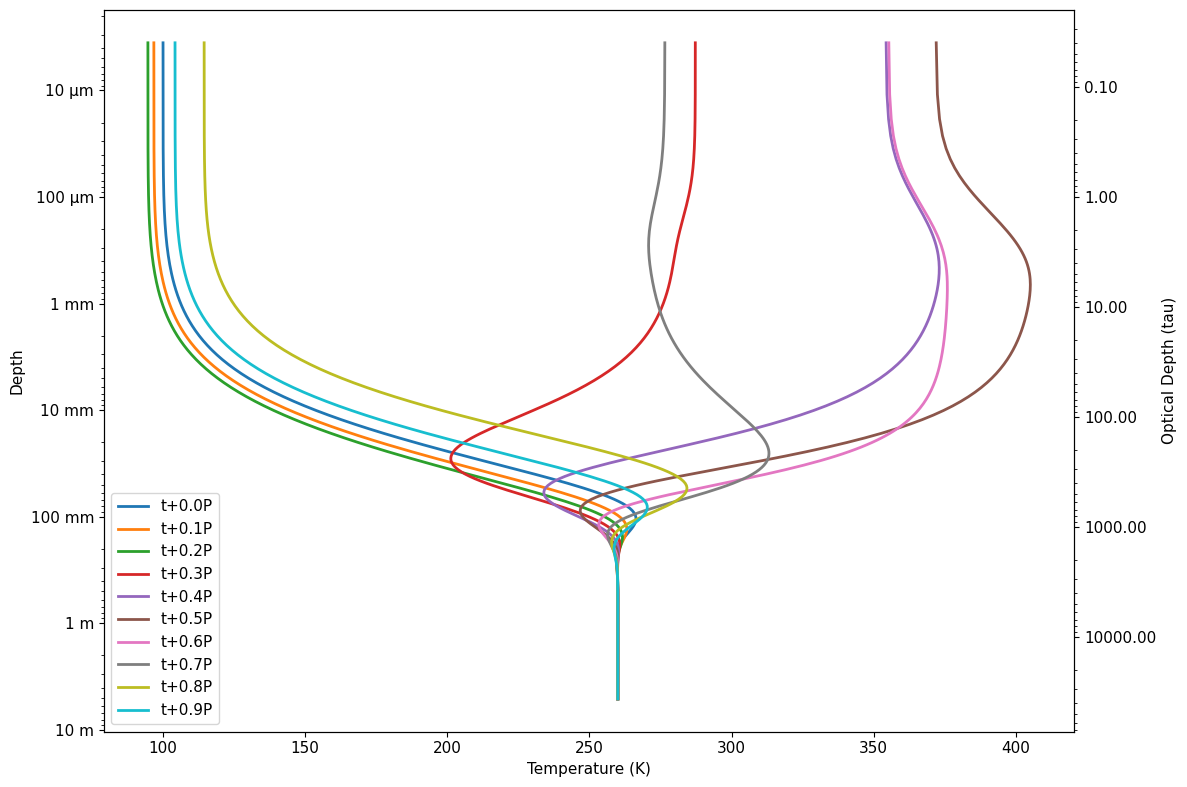

In [8]:
from matplotlib.ticker import FuncFormatter, LogLocator

# Plot temperature profiles vs depth (log scale) with a second y-axis for tau (opacity, non-log)
fig, ax1 = plt.subplots()
time_fracs = np.linspace(0, 1, len(sim1.t_out))
plot_fracs = np.linspace(0, 0.9, 10)
for frac in plot_fracs:
    idx = np.argmin(np.abs(time_fracs - frac))
    if hasattr(sim1.cfg.Et,'shape'):
        x_m = sim1.grid.x[1:] / sim1.cfg.Et[1:]
    else:
        x_m = sim1.grid.x[1:] / sim1.cfg.Et
    ax1.plot(T_out1[1:, idx], x_m, label=f't+{frac:.1f}P')

ax1.set_ylabel('Depth')
ax1.set_xlabel('Temperature (K)')
ax1.legend()
ax1.invert_yaxis()

# Set custom ticks for more human-readable units
def depth_formatter(x, pos):
    if x < 1e-3:
        return f"{x*1e6:.0f} µm"
    elif x < 1:
        return f"{x*1e3:.0f} mm"
    else:
        return f"{x:.0f} m"

ax1.set_yscale('log')
ax1.yaxis.set_major_locator(LogLocator(base=10))
ax1.yaxis.set_major_formatter(FuncFormatter(depth_formatter))

# Add a second y-axis for tau (opacity)
def tau_formatter(tau, pos):
    return f"{tau:.2f}"

# Create the secondary axis
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
# Convert the log-scale x_m limits back to tau
ylim = ax1.get_ylim()
if hasattr(sim1.cfg.Et,'shape'):
    tau_min = ylim[0] * sim1.cfg.Et[1]
    tau_max = ylim[1] * sim1.cfg.Et[-1]
else:
    tau_min = ylim[0] * sim1.cfg.Et
    tau_max = ylim[1] * sim1.cfg.Et
ax2.set_yscale('log')
ax2.set_ylim(tau_min, tau_max)
ax2.yaxis.set_major_locator(LogLocator(base=10))
ax2.yaxis.set_major_formatter(FuncFormatter(tau_formatter))
ax2.set_ylabel('Optical Depth (tau)')

plt.tight_layout()
plt.show()

## Plot diurnal brightness temperatures

Auto-detected simulation object, extracting data...
Computing surface radiances for 6 observers and 96 time points...
  Observer 1/6 (mu=1.000, angle=0.0°)
  Observer 2/6 (mu=0.940, angle=20.0°)
  Observer 3/6 (mu=0.766, angle=40.0°)
  Observer 4/6 (mu=0.500, angle=60.0°)
  Observer 5/6 (mu=0.174, angle=80.0°)
  Observer 6/6 (mu=0.035, angle=88.0°)
Surface radiance calculation completed.


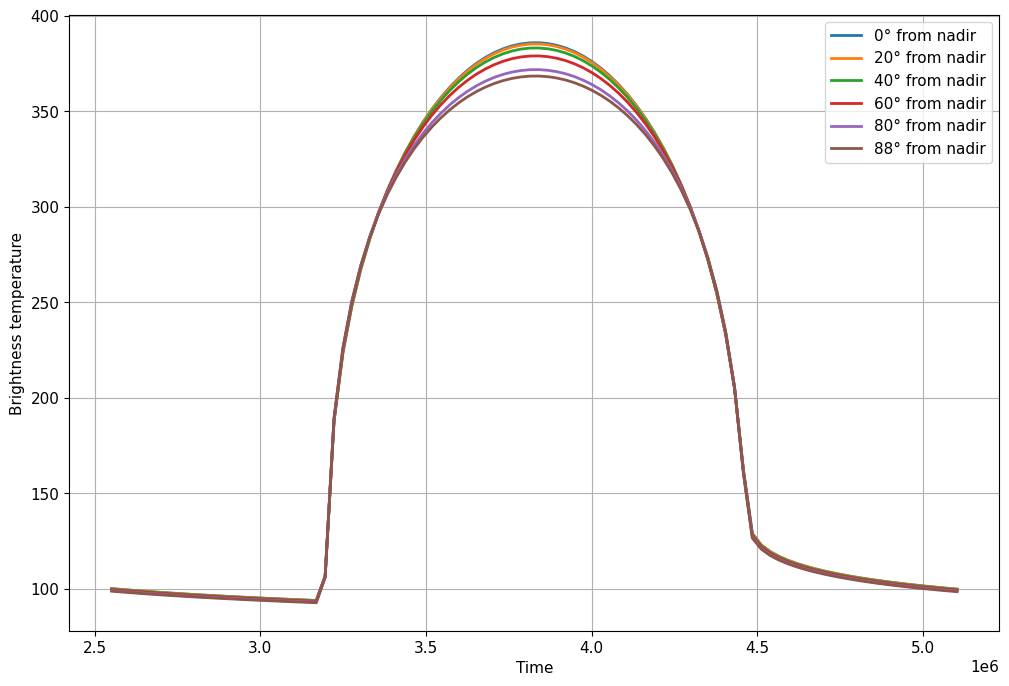

In [9]:
angles = [0,20,40,60,80,88]

spec_results = calculate_radiances_from_results(
    sim1, surface_type='smooth', observer_angles = angles
)


# Calculate emissivity for each angle (using same approach as before)
for i, angle in enumerate(angles):
    btemp = (spec_results['radiance_thermal'][i,:]*np.pi/5.67e-8)**0.25
    
    # Plot normalized emissivity spectrum
    plt.plot(spec_results['times'], btemp, 
             label=f'{angle:.0f}° from nadir', linewidth=2)

plt.ylabel('Brightness temperature')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
angles2 = [0,45,90]
sim1.cfg.scale_Et = False

spec_results_multi = calculate_radiances_from_results(
    sim1, surface_type='smooth', observer_angles = angles2,spectral_mode='hybrid'
)

Auto-detected simulation object, extracting data...
Computing surface radiances for 3 observers and 96 time points...
  Observer 1/3 (mu=1.000, angle=0.0°)
  Observer 2/3 (mu=0.707, angle=45.0°)
  Observer 3/3 (mu=0.000, angle=90.0°)
Surface radiance calculation completed.


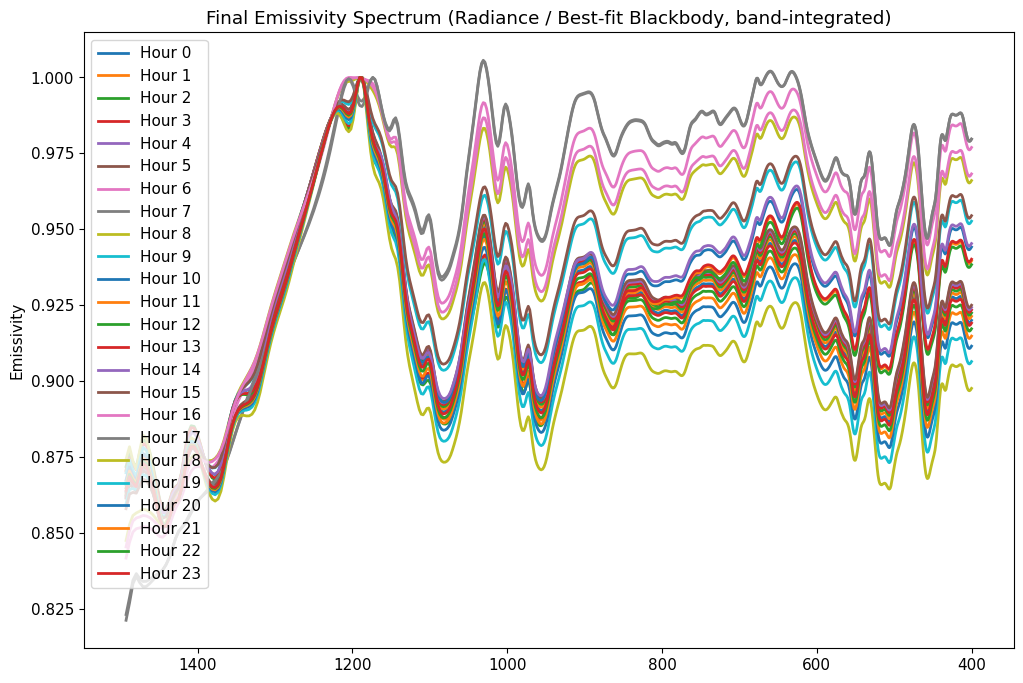

In [11]:

wn_bounds = np.sort(np.loadtxt(sim1.cfg.wn_bounds_out))
wn = spec_results_multi['wavenumbers']

from modelmain import max_btemp_blackbody

angle_idx = 0
# Calculate emissivity for each angle (using same approach as before)
for i, hour in enumerate(spec_results_multi['time_indices']):
    if i%4: continue
    final_rad_angle = spec_results_multi['radiance_thermal'][angle_idx,:,i]  # Final time step
    
    # Calculate blackbody fit for this angle's radiance
    T_fit, B_fit, btemps, wn_BB = max_btemp_blackbody(sim1, wn_bounds, final_rad_angle,idx=i,wn_min = 1100, wn_max = 1500)
    emiss_spec_angle = final_rad_angle / B_fit
    
    # Normalize emissivity
    idx1 = np.argmin(np.abs(wn - 1100))
    idx2 = np.argmin(np.abs(wn - 1300))
    cf_emis = emiss_spec_angle[idx1:idx2+1].max()
    
    # Plot normalized emissivity spectrum
    plt.plot(wn, emiss_spec_angle +1 - cf_emis, 
             label=f'Hour {24*i/len(spec_results_multi['time_indices']):.0f}', linewidth=2)
    

plt.ylabel('Emissivity')
plt.title('Final Emissivity Spectrum (Radiance / Best-fit Blackbody, band-integrated)')
plt.legend()
#plt.grid(True)
plt.gca().invert_xaxis()
plt.show()


In [12]:
# Import the interactive plotter
from postprocessing.interactive_plotter import plot_thermal_spectral_results

# Create interactive plots with the existing simulation data
# Using the sim1 object that was already created and computed above
try:
    plotter = plot_thermal_spectral_results(
        sim1, 
        observer_angles=[0, 45, 90],
        time_subsample=50  # Use 50 time points for performance
    )
    
    plt.show()
    print("Interactive plotter created successfully!")
    print("Use the sliders below the plots to:")
    print("- Time slider: Scrub through different time steps")
    print("- Angle slider: Change emission/viewing angle")
    
except Exception as e:
    print(f"Error creating interactive plots: {e}")
    import traceback
    traceback.print_exc()

Computing spectral radiance data...
Auto-detected simulation object, extracting data...
Computing surface radiances for 3 observers and 96 time points...
  Observer 1/3 (mu=1.000, angle=0.0°)


KeyboardInterrupt: 

In [ ]:
# Example 1: Using the simulator object directly (simplest)
print("Creating interactive plot from simulator object...")
plotter1 = plot_thermal_spectral_results(
    sim1, 
    observer_angles=[0, 45, 90],
    time_subsample=25,  # Use every 25th time step for performance
    figsize=(18, 10)
)
plt.show()

In [ ]:
# Example 2: Using pre-computed multispectral results (spec_results_multi)
# This uses the hybrid spectral mode data already computed above

print("Creating interactive plot from pre-computed multispectral results...")
print(f"Spectral data shape: {spec_results_multi['radiance_thermal'].shape}")
print(f"Observer angles: {angles2}")
print(f"Time points: {len(spec_results_multi['time_indices'])}")

# Create a modified simulator-like object with the pre-computed spectral data
class SpectralDataContainer:
    """Container to pass pre-computed spectral data to the plotter"""
    def __init__(self, sim, spec_results, observer_angles):
        # Copy simulator attributes
        self.cfg = sim.cfg  
        self.grid = sim.grid
        self.T_out = sim.T_out
        self.T_surf = sim.T_surf 
        self.t_out = sim.t_out
        
        # Override with pre-computed spectral results
        self.spec_results_override = spec_results
        self.observer_angles_override = observer_angles

# Create container with multispectral results
spectral_container = SpectralDataContainer(sim1, spec_results_multi, angles2)

try:
    plotter2 = plot_thermal_spectral_results(
        spectral_container,
        observer_angles=angles2,  # Use the angles from spec_results_multi: [0, 45, 90]
        time_subsample=None,      # Use all time points since we have fewer
        figsize=(18, 10)
    )
    
    # Override the spectral results in the plotter to use pre-computed data
    plotter2.spec_results = spec_results_multi
    plotter2._update_plots(init=True)  # Reinitialize with new data
    
    plt.show()
    
    print("Interactive plotter created with multispectral data!")
    print("Features:")
    print("- Time slider: Navigate through diurnal cycle")
    print("- Angle slider: Switch between viewing angles (0°, 45°, 90°)")
    print("- Panel 1: Temperature profiles at different times")
    print("- Panel 2: Brightness temperature vs time with moving marker")
    print("- Panel 3: Emissivity spectra (calculated from radiance/blackbody)")
    
except Exception as e:
    print(f"Error with multispectral plotter: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
# Example 3: Compare broadband vs multispectral results side by side
print("Creating comparison plots...")

# Create a figure with two sets of interactive plots
fig_compare = plt.figure(figsize=(20, 12))

# First subplot: Broadband results (spec_results)
plt.subplot(2, 1, 1)
plt.title("Broadband Results", fontsize=14, weight='bold')

if 'spec_results' in locals():
    print("Plotting broadband brightness temperatures...")
    for i, angle in enumerate(angles):
        if i < len(spec_results['radiance_thermal']):
            btemp_broadband = (spec_results['radiance_thermal'][i,:]*np.pi/5.67e-8)**0.25
            plt.plot(spec_results['times']/3600, btemp_broadband, 
                    label=f'{angle:.0f}° broadband', linewidth=2, linestyle='-')

# Second subplot: Multispectral results
plt.subplot(2, 1, 2) 
plt.title("Multispectral Results", fontsize=14, weight='bold')

print("Plotting multispectral brightness temperatures...")
for i, angle in enumerate(angles2):
    btemp_multi = (spec_results_multi['radiance_thermal'][i,:]*np.pi/5.67e-8)**0.25
    plt.plot(spec_results_multi['times']/3600, btemp_multi, 
            label=f'{angle:.0f}° multispectral', linewidth=2, linestyle='--')

plt.xlabel('Time (hours)')
plt.ylabel('Brightness Temperature (K)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\\nComparison complete!")
print("- Solid lines: Broadband radiance results")
print("- Dashed lines: Multispectral (hybrid) radiance results")
print("- Different angles show viewing geometry effects")